In [30]:
import emcee
import corner
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.stats import norm

np.random.seed(8)

# Problem 1: Importance Sampling

Load the Line Fitting dataset (line_fitting.csv) and plot the data.

Fit a model to the data using:
a. Uniform priors on all parameters
b. Modestly informative Gaussian priors on all parameters
c. Strongly informative Gaussian priors on all parameters

Draw samples from the posterior using any sampler of your choosing.

After sampling in cases (b) and (c), calculate importance weights and resample your posteriors in order to "undo" the informative prior. This step will create a vector of unweighted posterior samples from your original vector of weighted posterior samples. Verify that after importance sampling your results are equivalent to what you obtained in case (a).

Examine the posterior distributions. Do you see any numerical noise or other sampling artifacts introduced by importance sampling?

In [3]:
t = Table.read('line_fitting.csv')
t.remove_column('col0')

x = t['x'].value
y = t['y'].value
y_err = t['y_err'].value

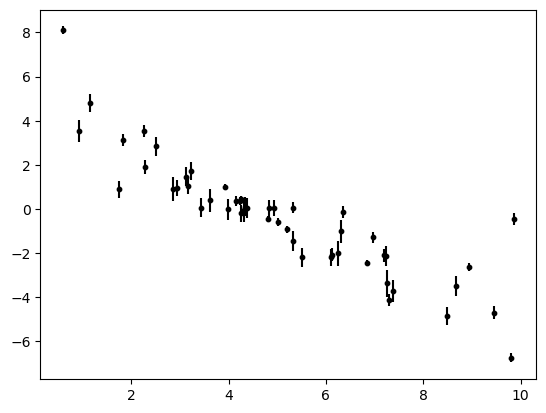

In [5]:
plt.scatter(x, y, s=10, color='black')
plt.errorbar(x, y, yerr=y_err, linestyle='None', color='black')
plt.show()

In [48]:
def lnprior_uniform(theta):
    m, b = theta
    if -100 <= m <= 0 and -100 <= b <= 100:
        lnp = np.log(1/100) + np.log(1/200)
    else:
        lnp = -np.inf
    return lnp

def lnprior_modgauss(theta):
    m, b = theta
    mp = norm.logpdf(m, -1.1, 1)
    bp = norm.logpdf(b, 5.4, 1)
    lnp = mp + bp
    return lnp

def lnprior_strgauss(theta):
    m, b = theta
    mp = norm.logpdf(m, -1.1, 0.05)
    bp = norm.logpdf(b, 5.44, 0.1)
    lnp = mp + bp
    return lnp

def prior_modgauss(theta):
    m, b = theta
    mp = norm.pdf(m, -1.1, 1)
    bp = norm.pdf(b, 5.4, 1)
    lnp = mp + bp
    return lnp

def prior_strgauss(theta):
    m, b = theta
    mp = norm.pdf(m, -1.1, 0.05)
    bp = norm.pdf(b, 5.44, 0.1)
    lnp = mp + bp
    return lnp

In [15]:
def lnlikelihood(theta, x, y, y_unc):
    m, b = theta
    model_preds = m*x + b
    lnl = -1 * np.sum(((y - model_preds)**2)/(2*y_unc**2)) # complete
    return lnl

def lnposterior(theta, x, y, y_unc, prior=lnprior_uniform):
    lnp = prior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    lnl = lnlikelihood(theta, x, y, y_unc)
    lnpost = lnl + lnp 
    return lnpost

In [32]:
nwalkers = 10
nsteps = 10000

#Generating initial positions
p0 = np.vstack([np.random.uniform(-10, 0, size=nwalkers), np.random.uniform(0, 10, size=nwalkers)]).T

50th percentile for m: -1.1037262732205222
50th percentile for b: 5.438530540542461


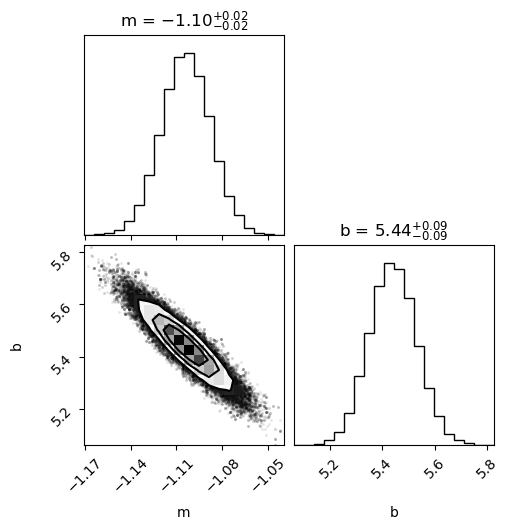

In [33]:
#UNIFORM PRIORS

#Making the sampler
sampler_uniform = emcee.EnsembleSampler(nwalkers, 2, lnposterior, args=[x, y, y_err, lnprior_uniform])

#Burn in
burnin_state_uniform = sampler_uniform.run_mcmc(p0, 1000)
sampler_uniform.reset()

#Doing the sampling
_ = sampler_uniform.run_mcmc(burnin_state_uniform, nsteps)

#Retrieve results
samples_uniform = sampler_uniform.get_chain()

#Save the 50th percentile of the parameters
values50_uniform = {}
for n, param in enumerate(['m', 'b']):
    values50[param] = np.median(samples_uniform[500:,:,n])
    print(f'50th percentile for {param}: {np.median(samples_uniform[500:,:,n])}')

#Corner plot
fig = corner.corner(sampler_uniform.get_chain(flat=True), labels=['m', 'b'], show_titles=True)

50th percentile for m: -1.1040841319484092
50th percentile for b: 5.439801987145113


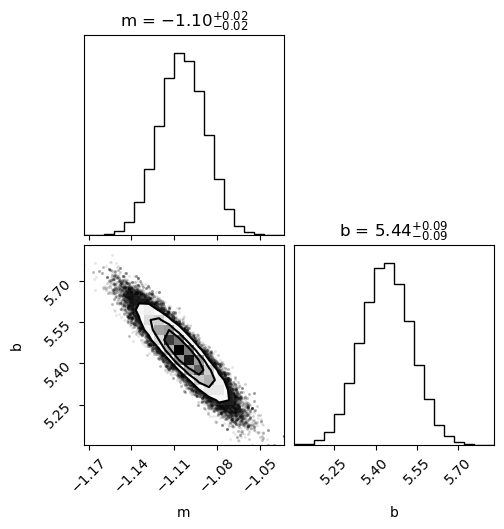

In [38]:
#MODERATE GAUSSIAN PRIORS

#Making the sampler
sampler_modgauss = emcee.EnsembleSampler(nwalkers, 2, lnposterior, args=[x, y, y_err, lnprior_modgauss])

#Burn in
burnin_state_modgauss = sampler_modgauss.run_mcmc(p0, 1000)
sampler_modgauss.reset()

#Doing the sampling
_ = sampler_modgauss.run_mcmc(burnin_state_modgauss, nsteps)

#Retrieve results
samples_modgauss = sampler_modgauss.get_chain()
samples_modgauss_flat = sampler_modgauss.get_chain(flat=True)

#Save the 50th percentile of the parameters
values50_modgauss = {}
for n, param in enumerate(['m', 'b']):
    values50[param] = np.median(samples_modgauss[500:,:,n])
    print(f'50th percentile for {param}: {np.median(samples_modgauss[500:,:,n])}')

#Corner plot
fig = corner.corner(samples_modgauss_flat, labels=['m', 'b'], show_titles=True)

50th percentile for m: -1.1037081300248304
50th percentile for b: 5.439157894794986


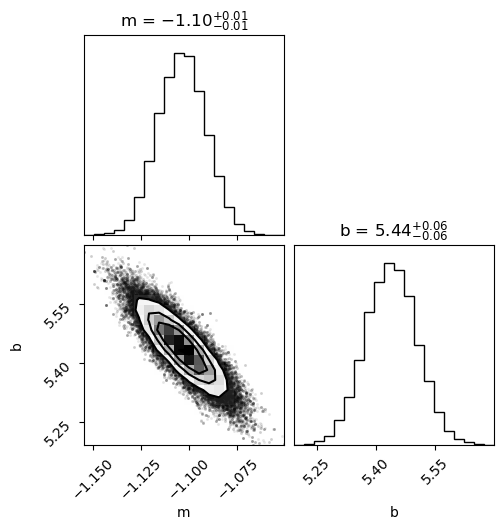

In [39]:
#STRONG GAUSSIAN PRIORS

#Making the sampler
sampler_strgauss = emcee.EnsembleSampler(nwalkers, 2, lnposterior, args=[x, y, y_err, lnprior_strgauss])

#Burn in
burnin_state_strgauss = sampler_strgauss.run_mcmc(p0, 1000)
sampler_strgauss.reset()

#Doing the sampling
_ = sampler_strgauss.run_mcmc(burnin_state_strgauss, nsteps)

#Retrieve results
samples_strgauss = sampler_strgauss.get_chain()
samples_strgauss_flat = sampler_strgauss.get_chain(flat=True)

#Save the 50th percentile of the parameters
values50_strgauss = {}
for n, param in enumerate(['m', 'b']):
    values50[param] = np.median(samples_strgauss[500:,:,n])
    print(f'50th percentile for {param}: {np.median(samples_strgauss[500:,:,n])}')

#Corner plot
fig = corner.corner(samples_strgauss_flat, labels=['m', 'b'], show_titles=True)

<font color='red'>**Goal of importance sampling**: Now that we have our posterior chain, which was produced with a certain prior, we want to redraw the posterior with new weights to undo the effect of the prior. So we want to draw random samples from the posterior samples that we've already drawn, weighted by the inverse of the Gaussian prior. (We can use `np.random.choice` for this, calculating the weights for each posterior sample by feeding in our values of m and b and then feeding those in as the probabilities).</font>

<font color='red'>In general, your weights are f/g, where g is the bias prior that you've applied and f is the target prior. Uniform priors always return 1, so you will have 1 on top in this case (or some other constant, but constant values don't matter for weights).</font>

50th percentile for m: -1.1039415885202692
50th percentile for b: 5.43930080068267


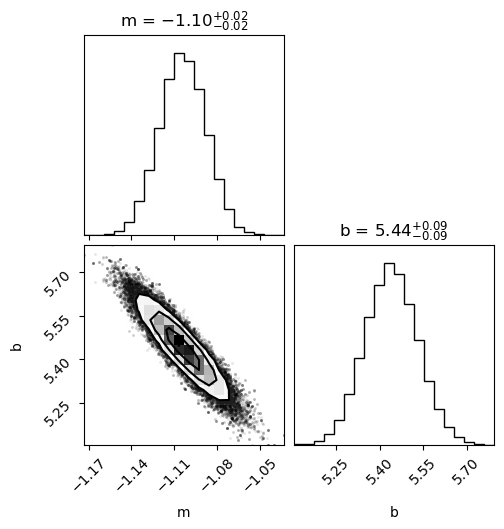

In [68]:
#REWEIGHTING: MODGAUSS -> UNIFORM

#Calculate prior at posterior values
#Assuming our uniform distribution just returns 1 (even tho it's slightly different) because constant values don't matter in weights
modgauss_weights = 1/prior_modgauss((samples_modgauss_flat[:,0], samples_modgauss_flat[:,1]))
modgauss_weights /= np.sum(modgauss_weights)

#Redraw posterior, weighting with these priors
#Drawing indices so I can then apply them to each dimension of the array
reweighted_inds = np.random.choice(np.arange(len(modgauss_weights), dtype=int), size=len(modgauss_weights), p=modgauss_weights)
reweighted_samples_modgauss_flat = samples_modgauss_flat[reweighted_inds,:]

#Results
for n, param in enumerate(['m', 'b']):
    p50 = np.median(reweighted_samples_modgauss_flat[:,n])
    print(f'50th percentile for {param}: {p50}')

#Corner plot
fig = corner.corner(reweighted_samples_modgauss_flat, labels=['m', 'b'], show_titles=True)

50th percentile for m: -1.1038851555309197
50th percentile for b: 5.439957422262658


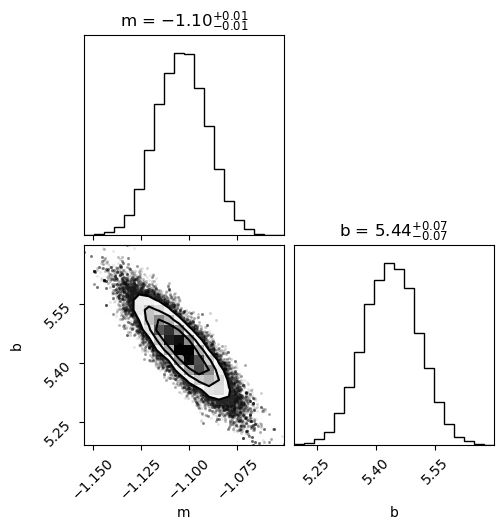

In [69]:
#REWEIGHTING: STRGAUSS -> UNIFORM

#Calculate prior at posterior values
#Assuming our uniform distribution just returns 1 (even tho it's slightly different) because constant values don't matter in weights
modgauss_weights = 1/prior_strgauss((samples_strgauss_flat[:,0], samples_strgauss_flat[:,1]))
modgauss_weights /= np.sum(modgauss_weights)

#Redraw posterior, weighting with these priors
#Drawing indices so I can then apply them to each dimension of the array
reweighted_inds = np.random.choice(np.arange(len(modgauss_weights), dtype=int), size=len(modgauss_weights), p=modgauss_weights)
reweighted_samples_strgauss_flat = samples_strgauss_flat[reweighted_inds,:]

#Results
for n, param in enumerate(['m', 'b']):
    p50 = np.median(reweighted_samples_strgauss_flat[:,n])
    print(f'50th percentile for {param}: {p50}')

#Corner plot
fig = corner.corner(reweighted_samples_strgauss_flat, labels=['m', 'b'], show_titles=True)

<font color='red'>I don't see anything weird from the importance sampling? Is that maybe just because this problem is pretty straightforward and well-defined already?</font>

# Problem 2: Umbrella Sampling Tutorial

Work through the umbrella sampling tutorial here: https://gjgilbert.github.io/tutorials/umbrella_sampling/

Once you complete the tutorial, return to the Line Fitting dataset from Problem 1. Fit a model using umbrella sampling. You'll need to choose how to define your umbrella windows and biases - there are many possible solutions! After sampling from individual umbrellas, combine your samples into a single set of posterior samples. Verify that the results you obtain from umbrella sampling are equivalent to the results you obtain from other methods.

# Problem 3: Reparameterizing a Model

Read in the Two Component Sinusoid dataset (two_component_sinusoid.csv) and plot the data.

Fit a model using the most "obvious" parameterization:

$y(x) = A_1 \sin(2\pi f_1 x - \phi_1 + A_2 \sin(2\pi f_2 x - \phi_2)$

Place appropriate independent priors on each of the six free parameters. Try fitting a model, drawing samples using a sampler of your choosing. Check for convergence and assess the quality of your results. Re-run your model a few times and check if your results remain consistent from run-to-run.

You will probably not acheive a very good fit using this parameterization. Why is this parameterization problematic? Re-parameterize the model in order to get a more robust fit. Check for convergence and that your posteriors remain consistent from run-to-run.